## Google OCR 사용하기

In [78]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, "rb") as image_file:
        content = image_file.read()
        
    image    = vision.Image(content = content)
    
    response = client.text_detection(image = image)
    texts    = response.text_annotations
    print("Texts : ")
    
    for text in texts:
        print("\n '{}'".format(text.description))
        
    vertices = (["({}, {})".format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])
    
    print("bounds : {}".format(",".join(vertices)))
    
    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check : "
            "https://cloud.google.com/apis/design/errors".format(response.error.message))

In [79]:
# 위의 함수가 잘 작동하는지 노드에서 실행했던 것으로 테스트 해보기

# 다운받은 인증키 경로가 정확하게 지정되어 있어야 한다.
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("HOME") + "/aiffel/ocr_python/my_google_api_key.json"

# 입력 이미지 경로를 지정해 줘야 한다.
path = os.getenv("HOME") + "/aiffel/ocr_python/test_image.png"

# 위에서 정의한 OCR API 이용 함수를 호출해 본다.
detect_text(path)

-rw-rw-r-- 1 aiffel-dj52 aiffel-dj52 2352  3월 16 11:16 /home/aiffel-dj52/aiffel/ocr_python/my_google_api_key.json
Texts : 

 'f odprofll
1 Stück/pièce
(20g
431 kcal) |(86 kc 1 4%
0,6g 1%
14,4g 5%
10,6g 12%
2,8g 4%
10
Stück
pièces
pezzi
100g
200g
3g
72g
53g
14g
7 610807 029987 (10x20g)
DA
8g
1,6g 8%
verkaufen bis:
vendre jusqu'au:
vendere ent o:
0,2g 1%
1g
) 07g
0,01g 0%
11.04.2012
mindestens haltbar bis:
consommer préf. av.:
consumare pref. entro:
0,2g
0,04
1%
/des reperes nutritio nels
foodprofil
25.04.2012
'

 'f'

 'odprofll'

 '1'

 'Stück/pièce'

 '(20g'

 '431'

 'kcal)'

 '|(86'

 'kc'

 '1'

 '4%'

 '0,6g'

 '1%'

 '14,4g'

 '5%'

 '10,6g'

 '12%'

 '2,8g'

 '4%'

 '10'

 'Stück'

 'pièces'

 'pezzi'

 '100g'

 '200g'

 '3g'

 '72g'

 '53g'

 '14g'

 '7'

 '610807'

 '029987'

 '(10x20g)'

 'DA'

 '8g'

 '1,6g'

 '8%'

 'verkaufen'

 'bis:'

 'vendre'

 'jusqu'au:'

 'vendere'

 'ent'

 'o:'

 '0,2g'

 '1%'

 '1g'

 ')'

 '07g'

 '0,01g'

 '0%'

 '11.04.2012'

 'mindestens'

 '

####  Google OCR은 이상없이 작동 된다.

## keras-ocr 사용하기

In [80]:
import keras_ocr
import matplotlib.pyplot as plt # keras-ocr의 인식결과를 시각화 하기 위해 불러온다.

# keras-ocr이 detector와 recognizer를 위한 모델을 자동으로 다운로드 받게 된다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj52/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj52/.keras-ocr/crnn_kurapan.h5


In [81]:
# keras-ocr 또한 노드에서 한 대로 코딩을 해서 테스트를 해본다.

# 테스트에 사용할 이미지 url을 모아 본다. 추가로 더 모아도 된다.
image_urls = [
  "https://source.unsplash.com/M7mu6jXlcns/640x460",
  "https://source.unsplash.com/6jsp4iHc8hI/640x460",
  "https://source.unsplash.com/98uYQ-KupiE",
  "https://source.unsplash.com/j9JoYpaJH3A",
  "https://source.unsplash.com/eBkEJ9cH5b4"
]

images            = [keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


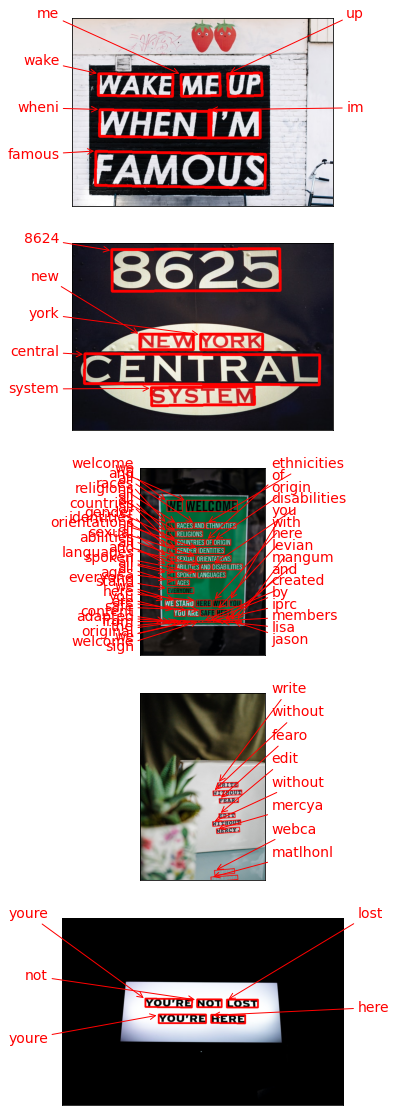

In [82]:
# keras-ocr 인식결과를 시각화 해본다.

# Plot the predictions
fig, axs = plt.subplots(nrows = len(images), figsize = (20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image = images[idx], predictions = prediction_groups[idx][0], ax = ax)

#### keras-ocr도 이상없이 잘  작동했다.

## Tesseract 사용하기

In [86]:
# 테서렉트로 문자 검출하고 이미지 자르기(detection)
# 테서렉틀를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 하는데, 이런 OCR이 이뤄지는 전체과정을 직접 거쳐보기 위해 검출을 먼저 해봤다.

from PIL import Image
from pytesseract import Output

import os
import pytesseract
import numpy as np # 테서렉트의 검출 과정을 한 셀에서 보기 위해 array로 변환한다.

# OCCR Engine modes(-oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(-psm):
# 0 - Orientation and script detextion (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Degault)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path = "./images/sample.png", output_path = "./output"):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r"--oem 3 --psm 3"
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, 
        lang        = "eng", # 한국어라면 lang = "kor"
        config      = custom_oem_psm_config,
        output_type = Output.DICT
    )
    
    top_level               = max(recognized_data["level"])
    index                   = 0
    cropped_image_path_list = []
    
    for i in range(len(recognized_data["level"])):
        level = recognized_data["level"][i]
        
        if level == top_level:
            left   = recognized_data["left"][i]
            top    = recognized_data["top"][i]
            width  = recognized_data["width"][i]
            height = recognized_data["height"][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((left, top, left + width, top + height))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

work_dir      = os.getenv("HOME") + "/aiffel/ocr_python"
img_file_path = work_dir + "/test_image.png" # 테스트용 이미지 경로.

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel-dj52/aiffel/ocr_python/0000.png
/home/aiffel-dj52/aiffel/ocr_python/0001.png
/home/aiffel-dj52/aiffel/ocr_python/0002.png
/home/aiffel-dj52/aiffel/ocr_python/0003.png
/home/aiffel-dj52/aiffel/ocr_python/0004.png
/home/aiffel-dj52/aiffel/ocr_python/0005.png
/home/aiffel-dj52/aiffel/ocr_python/0006.png
/home/aiffel-dj52/aiffel/ocr_python/0007.png
/home/aiffel-dj52/aiffel/ocr_python/0008.png
/home/aiffel-dj52/aiffel/ocr_python/0009.png
/home/aiffel-dj52/aiffel/ocr_python/0010.png
/home/aiffel-dj52/aiffel/ocr_python/0011.png
/home/aiffel-dj52/aiffel/ocr_python/0012.png
/home/aiffel-dj52/aiffel/ocr_python/0013.png
/home/aiffel-dj52/aiffel/ocr_python/0014.png
/home/aiffel-dj52/aiffel/ocr_python/0015.png


* 위에서 구현한 crop_word_regions() 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.
* 기본적으로 pytesseract.image_to_data() 를 사용한다.
* 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결과값의 형식을 딕셔너리(DICT) 형식으로 설정해주게 된다. 
* 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 된다.
* 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴했다.

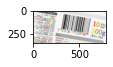

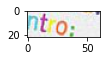

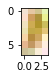

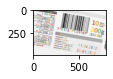

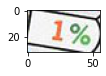

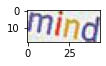

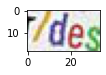

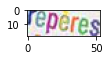

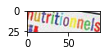

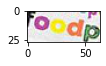

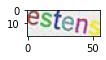

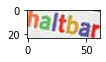

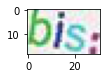

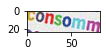

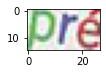

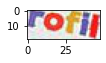

In [87]:
# 시각화를 위한 전처리
image_array_list = []

for i in range(len(cropped_image_path_list)):
    temp = Image.open(cropped_image_path_list[i])
    temp = np.array(temp)
    image_array_list.append(temp)
    
# 시각화하기
for i in range(len(image_array_list)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image_array_list[i])
    plt.show()

* 이제 문자 인식을 할 차례이다.
* 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 image_to_string()를 사용하면 된다.

In [88]:
# 테서렉트로 잘린 이미지에서 단어 인식하기
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r"--oem 3 --psm 7"
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image,
            lang        = "eng", # 한국어라면 lang = "kor"
            config      = custom_oem_psm_config,
            output_type = Output.DICT
        )
        print(recognized_data["text"])
    print("Done")
    
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력한다.
recognize_images(cropped_image_path_list)


Ntro.



| 1%)

Ming

/ das

'EDeres

NUtrition nels

ro. alg

CSten.

laltbar

Dis:

“ONSOmp

Ure

rOrii

Done


#### tesseract도 잘 작동한다.

## step1. 검증용 데이터셋 준비

* 오늘 해볼 것은 책 제목을 인식을 잘 하는지를 볼 것이다.
* 내가 서점에 가서 책을 찾고자 할 때 나보다는 기계가 훨씬 잘 찾고 놓치지 않을 거라 가정하에
* 서점에 가서 책 제목과 내가 미리 입력한 제목이 일치하면 알려주는 것이다.
* 그를 위해 회사에 있는 책 중 제목이 영어인 (원서라고 추측되는) 책들의 사진을 찍었다.

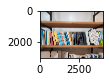

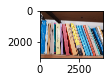

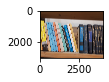

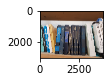

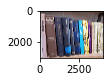

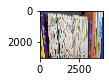

In [89]:
# 오늘 사용할 이미지들 보기

# 파일을 불러오기
images_path = []

for i in range(2, 8):
    image_path = os.getenv("HOME") + f"/aiffel/ocr_python/test_{i}_image.png"
    images_path.append(image_path)

# 시각화를 위한 전처리
image_array_list = []

for i in range(len(images_path)):
    temp = Image.open(images_path[i])
    temp = np.array(temp)
    image_array_list.append(temp)
    
# 시각화하기
for i in range(len(image_array_list)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image_array_list[i])
    plt.show()

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 2_1. Google OCR API

In [90]:
# 사진이 여러개 이므로 for문을 사용한다.

# 다운받은 인증키 경로가 정확하게 지정되어 있어야 한다.
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv("HOME") + "/aiffel/ocr_python/my_google_api_key.json"

for path in images_path:
    detect_text(path)

-rw-rw-r-- 1 aiffel-dj52 aiffel-dj52 2352  3월 16 11:16 /home/aiffel-dj52/aiffel/ocr_python/my_google_api_key.json
Texts : 

 'MOOL
Ssas
LEHMANN
Bickel
and
Doksum
강창완 강현철
김기한 이동희
전희주 진서훈
최병진 최종호
한상태 홍한표
공역
PAMANN
감수
JOHNSON JOHNSO OHNSON HNS
KOTZ KOTZ KOTZ KOT/.
한국패스소프웨어(주)
Senod
Edition
WILEY
WILEY
国
hd
HOLDEN DAY
상 장
(주)인사이트마이닝
대표이사 이 1
SISEIS
44
Minitab 신뢰성 분석
SAS
Minitab
Minitab 신뢰성분석
Minitab
Survey methods and practices Sutsaes Canada
품질관리과
Mialtab aue scr을 8t 예제중심의 실험계획법
Discrete
Multivariate
Analysis
Ca e ta-d7PE
SAS/E
시
Il a (Survey methods and practices)
Advanced SAS Programming
SPSS AIP
P반의 대이터미
SAS Certification Prep Guide
no 국제공인자격시험안내서
프로그램。
Categorical Data Analysis
Second Edition
The Analysis
of Variance
Ditribucions
Pregrem
Continuous univariata
distributions-2
In Statistics
Distributions
continuous univariate
distributions-1
in Satistics
Distributions
In Statistics
discrete distributions
Distributions
Continuous
Multivariate Distributions
In Statistics
LEHMANN
Testing S

Texts : 

 'LEHMANN
Bickel
and
Doksum
HMANN
JOHNSONOHNSO,OHNSODHNS
KOT. KOTA KOT
KOTZ
WILEY
WILEY
HOLDEN-DA
LOLL N
DAY
AAAAA
in Statistics
distributions-2
continuous univariate
Distributions
in Statistics
distributions-1
Discributions
In Statistics
discrete distributions
Distributions
Continuous
in Statistics
Multivariate Distributions
LEHM ANN
Testing Statistical
Hypotheses
NONPARAMETRICS:
STATISTICAL METHODS
BASED ON RANKS
MATHEMATICAL STATISTICS:
Basic Ideas and Selectèd Topics
THEORY OF
POINT ESTIMATION
Small Area Estimation
Model Selection
Statistical Modelling
GILCHRIST.
Applied. Bayesian and Classical Inference
The Case of The Federalist Papers
Tools for Statistical Inference.
Mosteller
Wallace
Urn Models and Their Application
Limited-dependent and qualitative
variables in econometrics
MADDALA
S Saftoh Integral transforms, reproducing kernels and their applications
The Physics of Chance
From Blaise Pascal to Niels Bohr
GRAPHICAL METHODS
FOR DATA ANALYSIS
Graphical Exploratory
Da

Texts : 

 'Miller
B.R.Cox and D.V. Hinkley
INTRODUCTI ON TO
THE THEORY OF NEURAL COMPUTATION
QUINLAN
PROGR AMS FOR MACHINE L EARNING
M. Vidyasagar ATheory of Learning and Generalization
A Sage University Paper: COMPUTER-ASSISTED INTERVIEWING
A Sage omiversity Paper. EXPERT S CMIS
Saris
07-080
SAGE
A Sage University Paper: DATA THEORY AND DIMENSIONAL ANALYSIS
JACOBY
07-078
SAGE
A Sage University Paper: REGRESSION DIAGNOSTICS
Fox
07-079
SAGE
SAGE
A Sage University Paper: CONTEXTUAL ANALYSIS
Iversen
07-081
A Sage University Paper: BASIO CONTENT ANALYSIS, Second Edition
Weber
07-049
SAGE
A Sage University Paper: TIME SERIES ANALYSIS, Second Editin
Ostrom
07-009
SAG
A Sage University Paper: PROCESSING DATA
Bourque/Clark
SAGE
07-085
A Sage University Paper: ANALYTIC MAPPING AND GEOGRAPHIC DATABASES
Garson/Biggs 07-087
SAGE
A Sage University Paper: WORKING WITH ARCHIVAL DATA
Elder/Pavalko/Clipp
07-088
SAGE
A Sage University Paper: MULTIPLE COMPARISON PROCEDURES
Toothaker
07-089
SAGE
Carmines

### 2_2. keras-ocr

In [91]:
images            = [keras_ocr.tools.read(path) for path in images_path]
prediction_groups = [pipeline.recognize([path]) for path in images_path]

/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


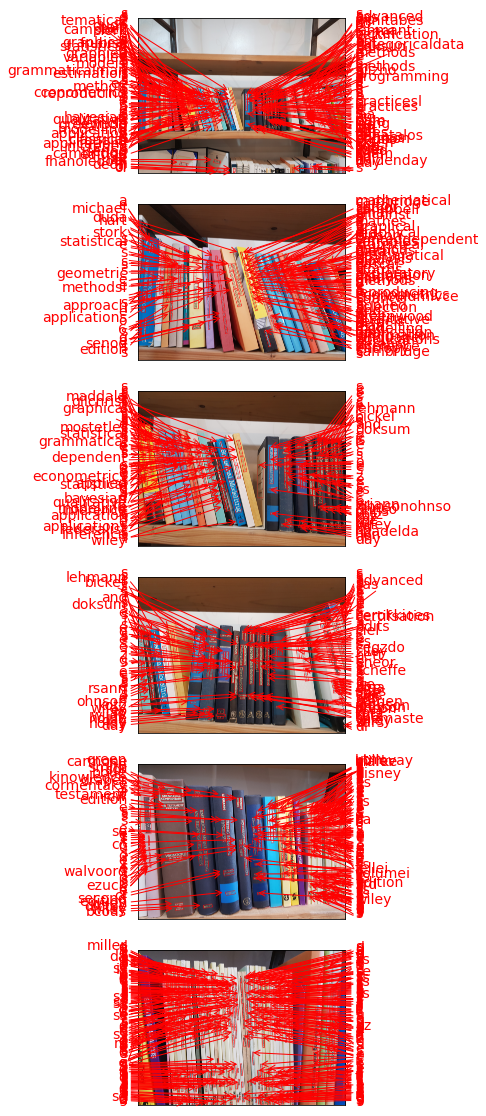

In [92]:
# keras-ocr 인식결과를 시각화 해본다.

# Plot the predictions
fig, axs = plt.subplots(nrows = len(images), figsize = (20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image = images[idx], predictions = prediction_groups[idx][0], ax = ax)

### 2_3. Tesseract

#### 2_3_1. 1번째 사진

In [114]:
img_file_path = work_dir + "/test_2_image.png" # 테스트용 이미지 경로.

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel-dj52/aiffel/ocr_python/0000.png
/home/aiffel-dj52/aiffel/ocr_python/0001.png
/home/aiffel-dj52/aiffel/ocr_python/0002.png
/home/aiffel-dj52/aiffel/ocr_python/0003.png
/home/aiffel-dj52/aiffel/ocr_python/0004.png
/home/aiffel-dj52/aiffel/ocr_python/0005.png
/home/aiffel-dj52/aiffel/ocr_python/0006.png
/home/aiffel-dj52/aiffel/ocr_python/0007.png
/home/aiffel-dj52/aiffel/ocr_python/0008.png
/home/aiffel-dj52/aiffel/ocr_python/0009.png
/home/aiffel-dj52/aiffel/ocr_python/0010.png
/home/aiffel-dj52/aiffel/ocr_python/0011.png
/home/aiffel-dj52/aiffel/ocr_python/0012.png
/home/aiffel-dj52/aiffel/ocr_python/0013.png
/home/aiffel-dj52/aiffel/ocr_python/0014.png
/home/aiffel-dj52/aiffel/ocr_python/0015.png
/home/aiffel-dj52/aiffel/ocr_python/0016.png
/home/aiffel-dj52/aiffel/ocr_python/0017.png
/home/aiffel-dj52/aiffel/ocr_python/0018.png
/home/aiffel-dj52/aiffel/ocr_python/0019.png
/home/aiffel-dj52/aiffel/ocr_python/0020.png
/home/aiffel-dj52/aiffel/ocr_python/0021.png
/home/aiff

SystemError: tile cannot extend outside image

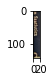

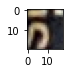

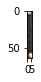

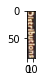

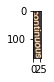

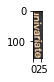

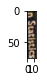

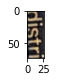

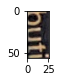

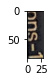

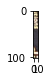

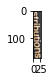

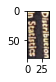

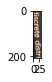

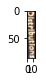

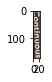

In [117]:
# 시각화를 위한 전처리
image_array_list = []

for i in range(len(cropped_image_path_list)):
    temp = Image.open(cropped_image_path_list[i])
    temp = np.array(temp)
    image_array_list.append(temp)
    
# 시각화하기
for i in range(len(image_array_list)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(image_array_list[i])
    plt.show()

In [118]:
# 테서렉트로 잘린 이미지에서 단어 인식하기
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r"--oem 3 --psm 7"
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image,
            lang        = "eng", # 한국어라면 lang = "kor"
            config      = custom_oem_psm_config,
            output_type = Output.DICT
        )
        print(recognized_data["text"])
    print("Done")
    
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력한다.
recognize_images(cropped_image_path_list)

,

ih


:






i

7


1


:


Done


#### 2_3_2. 2번째 사진

In [119]:
img_file_path = work_dir + "/test_3_image.png" # 테스트용 이미지 경로.

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel-dj52/aiffel/ocr_python/0000.png
/home/aiffel-dj52/aiffel/ocr_python/0001.png
/home/aiffel-dj52/aiffel/ocr_python/0002.png
/home/aiffel-dj52/aiffel/ocr_python/0003.png
/home/aiffel-dj52/aiffel/ocr_python/0004.png
/home/aiffel-dj52/aiffel/ocr_python/0005.png
/home/aiffel-dj52/aiffel/ocr_python/0006.png
/home/aiffel-dj52/aiffel/ocr_python/0007.png
/home/aiffel-dj52/aiffel/ocr_python/0008.png
/home/aiffel-dj52/aiffel/ocr_python/0009.png
/home/aiffel-dj52/aiffel/ocr_python/0010.png
/home/aiffel-dj52/aiffel/ocr_python/0011.png
/home/aiffel-dj52/aiffel/ocr_python/0012.png
/home/aiffel-dj52/aiffel/ocr_python/0013.png
/home/aiffel-dj52/aiffel/ocr_python/0014.png
/home/aiffel-dj52/aiffel/ocr_python/0015.png
/home/aiffel-dj52/aiffel/ocr_python/0016.png
/home/aiffel-dj52/aiffel/ocr_python/0017.png
/home/aiffel-dj52/aiffel/ocr_python/0018.png
/home/aiffel-dj52/aiffel/ocr_python/0019.png
/home/aiffel-dj52/aiffel/ocr_python/0020.png
/home/aiffel-dj52/aiffel/ocr_python/0021.png
/home/aiff

SystemError: tile cannot extend outside image

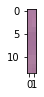

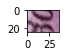

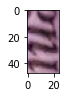

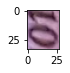

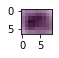

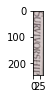

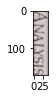

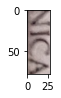

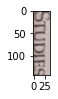

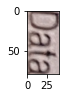

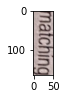

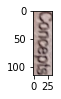

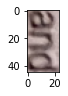

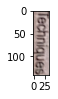

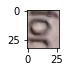

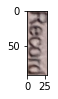

In [120]:
# 시각화를 위한 전처리
image_array_list = []

for i in range(len(cropped_image_path_list)):
    temp = Image.open(cropped_image_path_list[i])
    temp = np.array(temp)
    image_array_list.append(temp)
    
# 시각화하기
for i in range(len(image_array_list)):
    plt.subplot(3, 9, i + 1)
    plt.imshow(image_array_list[i])
    plt.show()

In [121]:
# 테서렉트로 잘린 이미지에서 단어 인식하기
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r"--oem 3 --psm 7"
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image,
            lang        = "eng", # 한국어라면 lang = "kor"
            config      = custom_oem_psm_config,
            output_type = Output.DICT
        )
        print(recognized_data["text"])
    print("Done")
    
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력한다.
recognize_images(cropped_image_path_list)

.

—

=

oO

*-



F

:

3

:

:

=


o

:

Done


## Step3. 테스트 결과 정리

### 3_1. Google OCR API

* 3개 중 가장 성능이 좋고 자세한 것 같다.
* 기대하지 않은 한글도 알아서 찾았고, 영어들도 찾았다.

### 3_2. keras-ocr

* 준수한 성능을 보였다.
* 시각화 해본 결과 영어에 한해서는 작은 글씨도 찾고, 책의 제목들에 있는 단어들을 잘 찾았다.

### 3_3. Tesseract

* 가장 성능이 안 좋았다.
* 이미지마다 tile을 벗어나는 구역이 있어서 끝까지 인식하지 못하고 도중에 에러가 뜬다.
* 에러가 뜨기 전에 사진으로 문자를 인식했을 때 알 수 없고 의미없는 글자만 출력되었다.

## Step4. 결과 분석과 결론 제시

* 우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
* 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
* 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

### 4_1. 구현하고자 하는 서비스의 목적과 내용

* 해보려고 하는 서비스는 서점에 가서 찾고자 하는 책의 이름을 입력한 뒤 카메라로 책을 보면 책의 제목을 읽어서 원하는 책이 있는지 찾는 서비스를 해보고 싶었다.

### 4_2. OCR 모델들이 목적에 부합했는지?

* Tesseract를 제외하고는 부합한 것 같다.
* 더 자세하게는 keras-ocr은 영어에 한해서만 부합할 것이고, Google OCR API는 영어, 한글 등 다양한 언어에서 부합할 것 같다.
* Tesseract가 한글이 지원된다고 하니 아마 이미지를 조금 수정하면 부합할 수 있을 수 있을 것이다.
* 평가 기준은 오로지 위의 결과로만 했다.

### 4_3. 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정한다.

* 위의 테스트 내용만 보고 정리해보자면 Google OCR API가 가장 좋은 모델일 것이다.
* 그 이유는 성능도 좋고, 따로 설정하지 않아도 알아서 영어와 한글 등 다양한 언어를 감지하고 인식했기 때문이다.

## 회고록

In [124]:
# 오늘의 노드는 이미 모델들이 코드로 잘 구현되어 있어서 코드실습은 어렵지 않았다.
# 하지만 OCR이란 개념을 배우는데 하루 중 70%의 시간은 쓰지 않았나 싶다.
# 노드의 설명 중 2018 deview 발표 영상이 있는데, 40분가량 영상이지만 앞에서 글로 쭉 읽으면서 잘 정리가 안되었던 개념들이
# 그 영상을 보고 어떤 느낌이겠다는 감을 잡을 수 있었다.
# cs231n을 보면서 간혹 CNN과 RNN이 합쳐진 모델의 그림을 보면서 두 모델을 합쳐서 쓰긴 하는구나..라고 생각은 했는데 오늘 SRNN이란 개념으로 배웠다.
# 이 분야는 자동차 번호판 인식, 실시간 번역 등 일상에서 매우 유용하고 상업적으로 가능성이 다양할 것 같아서 나중에 더 배워보고 싶은 분야가 되었다.